# Behavioural Development

The behavioral development score is based on the "Ages and Stages questionnaire". Information about it can be found in this [presentation](https://agesandstages.com/wp-content/uploads/2018/02/interpretingresults_slidepresentation_020818.pdf) and the original [paper](https://www.researchgate.net/publication/14006008_Revision_of_a_Parent-Completed_Developmental_Screening_Tool_Ages_and_Stages_Questionnaires). This questionnaire is used by doctors to assess the development of infants in different areas. 
The five categories that are assesed are:
- Communication
- Gross Motor
- Fine Motor
- Problem Solving
- Personal-Social

The parents of the infants fill out different questions for each category in the form. Based on the answers a score for each category is awarded. If the score of a category falls below a specified cut off, the infant is thought to show delayed development in this category.

This already shows the problem with the behavioral development score that we have in the met data. Our score seems to indicate the total points awarded to an infant overall five categories as developmental delay is determined for each category individually, a total score does not have much clinical relevance. This is illustrated nicely by an example:
- Imagine an infant scores perfectly in four of the five categories. In the last category it falls slightly below the cutoff, which indicates developmental delay.
- A different infant barely passes the cutoff value in all five categories, indicating no developmental delay.

Infant 1 will definitely receive a higher total score than Infant 2. This misses the developmental delay of Infant 1 and implies the developmental delay of Infant 2, which is not the case. Scores that fall below the cutoff in one category can be compensated by high scores in other categories. This makes it extremely difficult to assess whether an infant might show developmental delays simply based on a total score. In clinical practice, each category is looked at in an isolated way, and developmental status is assessed independently of the other categories. Therefore, the total score does not provide us with the needed information and misinterprets the "Ages and Stages questionnaire".


This notebook shows attempts at predicting the behavioural development score with microbiome data.

In [ ]:
import time
import warnings
import os

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from qiime2 import Artifact

data_dir = "../data"

plt.style.use("../presentation_style")

# Check if Source Sans Pro is available
fonts = [f.name for f in fm.fontManager.ttflist]
if "Source Sans Pro" not in fonts:
    plt.rcParams['font.family'] = 'sans-serif'
    print("Source Sans Pro not found, using default sans-serif font.")

%matplotlib inline

In [2]:
try:
    num_cpus = int(os.environ["SLURM_CPUS_PER_TASK"])
except KeyError:
    num_cpus = os.cpu_count()

In [3]:
metadata_per_sample = pd.read_csv(
    f"{data_dir}/raw/metadata_per_sample.tsv", sep="\t", index_col="sampleid"
)
metadata_per_sample["infant_id"] = metadata_per_sample["infant_id"].astype("category")

metadata_per_age = pd.read_csv(
    f"{data_dir}/raw/metadata_per_age.tsv", sep="\t", index_col=0
)

metadata = (
    metadata_per_sample.reset_index()
    .merge(right=metadata_per_age, how="left", on=["infant_id", "timepoint"])
    .set_index("sampleid")
)
metadata.head()

,infant_id,timepoint,sample_number,age_days,sex,feeding_method,birth_mode,collection_date,collection_site,behavioral_development,parent_attuned_caring_style,sleep_rhythmicity,sleep_quality
sampleid,,,,,,,,,,,,,
sample_1,1,2 months,1,69,Male,primarily breast-fed at enrolment,vaginal birth,2023,pediatrician x,300.0,3.307692,0.601667,0.477522
sample_2,1,2 months,2,69,Male,primarily breast-fed at enrolment,vaginal birth,2023,pediatrician x,300.0,3.307692,0.601667,0.477522
sample_3,1,2 months,3,69,Male,primarily breast-fed at enrolment,vaginal birth,2023,pediatrician x,300.0,3.307692,0.601667,0.477522
sample_4,1,2 months,4,70,Male,primarily breast-fed at enrolment,vaginal birth,2023,pediatrician x,300.0,3.307692,0.601667,0.477522
sample_5,1,2 months,5,71,Male,primarily breast-fed at enrolment,vaginal birth,2023,pediatrician x,300.0,3.307692,0.601667,0.477522


In [4]:
feature_table = Artifact.load(f"{data_dir}/raw/dada2_table.qza").view(pd.DataFrame)
features = feature_table.columns

In [5]:
data = pd.merge(left=metadata, right=feature_table, left_index=True, right_index=True)

print(f"Original dataset size: {len(data)} samples")
model_data = data.dropna(subset=["behavioral_development"])
print(
    f"Dataset size after removing missing behavioral development values: {len(model_data)} samples"
)
print(f"Number of samples lost: {len(data) - len(model_data)} samples")

model_data.behavioral_development.describe()

Original dataset size: 130 samples
Dataset size after removing missing behavioral development values: 103 samples
Number of samples lost: 27 samples


count    103.000000
mean     267.912621
std       30.482430
min      190.000000
25%      260.000000
50%      270.000000
75%      287.500000
max      300.000000
Name: behavioral_development, dtype: float64

In [6]:
import sklearn

sklearn.set_config(enable_metadata_routing=True)

from sklearn.pipeline import Pipeline
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import (
    KFold,
    LeaveOneGroupOut,
    LeavePGroupsOut,
    GridSearchCV,
    cross_val_predict,
    cross_validate,
    GroupKFold,
)
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor

from skbio.stats.composition import clr
from skbio.stats.composition import multi_replace

In [7]:
results_file_path = f"{data_dir}/results/model_performance_development.md"

# Create the results file and any missing directories
os.makedirs(os.path.dirname(results_file_path), exist_ok=True)
with open(results_file_path, "w") as f:
    f.write("# Predicting Behavioural Development: Model Performance\n\n")

def save_performance_metrics(cv_results, model_name, file_path=results_file_path):
    """
    Saves the performance metrics of a model to a markdown file.
    """
    # Ensure the directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    with open(file_path, "a") as f:
        f.write(f"## {model_name}\n\n")
        
        # Time metrics
        if 'fit_time' in cv_results:
            f.write(f"- **Mean Fit Time:** {cv_results['fit_time'].mean():.4f}s ± {cv_results['fit_time'].std():.4f}s\n")
        if 'score_time' in cv_results:
            f.write(f"- **Mean Score Time:** {cv_results['score_time'].mean():.4f}s ± {cv_results['score_time'].std():.4f}s\n")
        f.write("\n")

        # Score metrics
        # Identify metrics based on keys starting with 'test_'
        metrics = [key.replace('test_', '') for key in cv_results.keys() if key.startswith('test_')]
        
        for metric in metrics:
            test_key = f"test_{metric}"
            train_key = f"train_{metric}"
            
            test_scores = cv_results[test_key]
            
            # Flip sign for error metrics that are negative
            if metric in ['rmse', 'mae', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']:
                 display_test_scores = -test_scores
            else:
                 display_test_scores = test_scores
            
            f.write(f"### Metric: {metric.upper()}\n")
            f.write(f"- **Test Mean ± Std:** {display_test_scores.mean():.4f} ± {display_test_scores.std(ddof=1):.4f}\n")
            
            if train_key in cv_results:
                train_scores = cv_results[train_key]
                if metric in ['rmse', 'mae', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']:
                    display_train_scores = -train_scores
                else:
                    display_train_scores = train_scores
                f.write(f"- **Train Mean ± Std:** {display_train_scores.mean():.4f} ± {display_train_scores.std(ddof=1):.4f}\n")
            
            f.write("\n**Per-Fold Test Scores:**\n")
            for i, score in enumerate(display_test_scores):
                f.write(f"- Fold {i+1}: {score:.4f}\n")
            f.write("\n")

        f.write("### Best Parameters per Fold\n")
        if 'estimator' in cv_results:
            for i, estimator in enumerate(cv_results['estimator']):
                if hasattr(estimator, 'best_params_'):
                    f.write(f"- **Fold {i+1}:** {estimator.best_params_}\n")
                else:
                    f.write(f"- **Fold {i+1}:** Parameters not available\n")
        f.write("\n---\n\n")
    
    print(f"Performance metrics for '{model_name}' saved to {file_path}")

In [8]:
y = model_data.behavioral_development
X = model_data[features]

## Naive Approach

In the naive approach, we ignore the grouping structure of the data (multiple samples per infant) and perform simple nested cross-validation.
The results look quite good, but we need to be careful with overfitting and data leakage.

In [9]:
cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
cv_outer = KFold(n_splits=5, shuffle=True, random_state=2)

param_grid = {"lasso__alpha": np.logspace(-3, 1, num=10)}
best_params = {"lasso__alpha": []}

pipe = Pipeline(
    steps=[
        ("replace", FunctionTransformer(multi_replace)),
        ("clr", FunctionTransformer(clr, validate=False)),
        ("var", VarianceThreshold(1e-6)),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lasso", Lasso(max_iter=10000)),
    ]
)

model = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_inner,
    scoring="neg_root_mean_squared_error",
    n_jobs=num_cpus,
    error_score="raise",
    verbose=True,
)

# Nested CV with access to per-fold best params
scoring_metrics = {"rmse": "neg_root_mean_squared_error", "mae": "neg_mean_absolute_error", "r2": "r2"}
cv_results = cross_validate(
    estimator=model,
    X=X,
    y=y,
    cv=cv_outer,
    scoring=scoring_metrics,
    n_jobs=num_cpus,
    return_estimator=True,
    return_train_score=True,
    verbose=1,
)

y_pred = cross_val_predict(model, X=X, y=y, cv=cv_outer, n_jobs=num_cpus, verbose=True)

# pause for two seconds to let all threads finish printing their output
time.sleep(2)
print("\n*** Nested CV Results (Naive Approach) ***")
rmse_per_fold = -cv_results["test_rmse"]
print("Outer-CV RMSE mean ± sd:", rmse_per_fold.mean(), "±", rmse_per_fold.std(ddof=1))
best_alphas = [est.best_params_["lasso__alpha"] for est in cv_results["estimator"]]
print("Best alpha per outer fold:", best_alphas)

save_performance_metrics(cv_results, "Naive Approach (Nested CV)")

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    6.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    4.5s finished



*** Nested CV Results (Naive Approach) ***
Outer-CV RMSE mean ± sd: 16.49373787305933 ± 4.503943733854681
Best alpha per outer fold: [3.593813663804626, 0.05994842503189409, 0.007742636826811269, 0.001, 1.2915496650148828]
Performance metrics for 'Naive Approach (Nested CV)' saved to ../data/results/model_performance_development.md


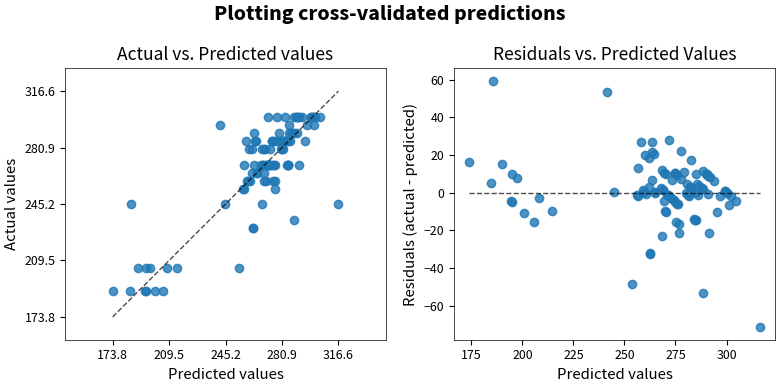

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values", fontweight="normal")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1],
)
axs[1].set_title("Residuals vs. Predicted Values", fontweight="normal")
fig.suptitle("Plotting cross-validated predictions", fontweight="bold")
fig.tight_layout()
fig.savefig("../figures/naive_nested_cv_predictions_behavior.pdf")
fig.show()

## Generalzation to unseen infants
In this approach, we take into account the grouping structure of the data and perform cross-validation such that all samples from a given infant are either in the training or test set.
This gives a more realistic estimate of model performance on unseen infants.

In [11]:
model_data.infant_id.nunique()

17

In [12]:
groups = model_data["infant_id"]

# cv_inner = LeavePGroupsOut(n_groups=3)
# cv_outer = LeavePGroupsOut(n_groups=3)

cv_inner = GroupKFold(n_splits=10)
cv_outer = GroupKFold(n_splits=10)

param_grid = {"lasso__alpha": np.logspace(-3, 1, num=10)}
best_params = {"lasso__alpha": []}

pipe = Pipeline(
    steps=[
        ("replace", FunctionTransformer(multi_replace)),
        ("clr", FunctionTransformer(clr, validate=False)),
        ("var", VarianceThreshold(1e-6)),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lasso", Lasso(max_iter=10000)),
    ]
)

model_loo = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_inner,
    scoring="neg_root_mean_squared_error",
    n_jobs=num_cpus,
    error_score="raise",
    verbose=True,
)

# Nested CV with access to per-fold best params
scoring_metrics = {"rmse": "neg_root_mean_squared_error", "mae": "neg_mean_absolute_error", "r2": "r2"}
cv_results = cross_validate(
    estimator=model_loo,
    X=X,
    y=y,
    params = {'groups': groups},
    cv=cv_outer,
    scoring=scoring_metrics,
    n_jobs=num_cpus,
    return_estimator=True,
    return_train_score=True,
    verbose=1,
    error_score="raise",
)

y_pred = cross_val_predict(
    model_loo, X=X, y=y, params = {'groups': groups}, cv=cv_outer, n_jobs=num_cpus, verbose=True
)

# pause for two seconds to let all threads finish printing their output
time.sleep(2)
print("\n*** Nested CV Results (Leave-P-Groups-Out Approach) ***")
rmse_per_fold = -cv_results["test_rmse"]
print("Outer-CV RMSE mean ± sd:", rmse_per_fold.mean(), "±", rmse_per_fold.std(ddof=1))
best_alphas = [est.best_params_["lasso__alpha"] for est in cv_results["estimator"]]
print("Best alpha per outer fold:", best_alphas)

save_performance_metrics(cv_results, "Generalize to unseen infants: Group K-Fold (Lasso)")

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    7.8s remaining:   31.3s


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    9.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    8.0s remaining:   32.2s


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    9.1s finished



*** Nested CV Results (Leave-P-Groups-Out Approach) ***
Outer-CV RMSE mean ± sd: 27.193369225983197 ± 23.63603097900347
Best alpha per outer fold: [1.2915496650148828, 0.1668100537200059, 0.46415888336127775, 3.593813663804626, 1.2915496650148828, 0.05994842503189409, 3.593813663804626, 0.05994842503189409, 1.2915496650148828, 1.2915496650148828]
Performance metrics for 'Generalize to unseen infants: Group K-Fold (Lasso)' saved to ../data/results/model_performance_development.md


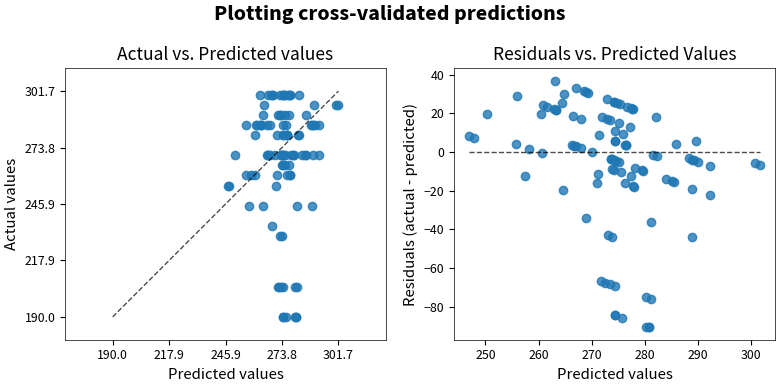

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values", fontweight="normal")

PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1],
)

axs[1].set_title("Residuals vs. Predicted Values", fontweight="normal")
fig.suptitle("Plotting cross-validated predictions", fontweight="bold")

fig.tight_layout()
fig.savefig("../figures/group_kfold_cv_predictions_behavior.pdf")
fig.show()

We see a huge drop in performance in this case. This is most likely due to the too optimistic prediction due to data leakage in the previous case.

We can try improving the model with some other approaches. We first try to perform PCA on the features to reduce the dimensionality. As this does not help, we try a different model, namely a Gradient Boosted Regressor.

In [14]:
groups = model_data["infant_id"]

# cv_inner = LeavePGroupsOut(n_groups=3)
# cv_outer = LeavePGroupsOut(n_groups=3)

cv_inner = GroupKFold(n_splits=10)
cv_outer = GroupKFold(n_splits=10)

param_grid = {"lasso__alpha": np.logspace(-3, 1, num=10),
              "pca__n_components": np.linspace(5, 50, num=10, dtype=int)}
best_params = {"lasso__alpha": [], "pca__n_components": []}

pipe = Pipeline(
    steps=[
        ("replace", FunctionTransformer(multi_replace)),
        ("clr", FunctionTransformer(clr, validate=False)),
        ("pca", PCA()),
        ("var", VarianceThreshold(1e-6)),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lasso", Lasso(max_iter=10000)),
    ]
)

model_loo = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_inner,
    scoring="neg_root_mean_squared_error",
    n_jobs=num_cpus,
    error_score="raise",
    verbose=True,
)

# Nested CV with access to per-fold best params
scoring_metrics = {"rmse": "neg_root_mean_squared_error", "mae": "neg_mean_absolute_error", "r2": "r2"}
cv_results = cross_validate(
    estimator=model_loo,
    X=X,
    y=y,
    params = {'groups': groups},
    cv=cv_outer,
    scoring=scoring_metrics,
    n_jobs=num_cpus,
    return_estimator=True,
    return_train_score=True,
    verbose=1,
    error_score="raise",
)

y_pred = cross_val_predict(
    model_loo, X=X, y=y, params = {'groups': groups}, cv=cv_outer, n_jobs=num_cpus, verbose=True
)

# pause for two seconds to let all threads finish printing their output
time.sleep(2)
print("\n*** Nested CV Results (Group K-Fold with PCA) ***")
rmse_per_fold = -cv_results["test_rmse"]
print(f"Outer-CV RMSE mean ± sd: {rmse_per_fold.mean():.2f} ± {rmse_per_fold.std(ddof=1):.2f}")
best_alphas = [est.best_params_["lasso__alpha"] for est in cv_results["estimator"]]
print("Best alpha per outer fold:", best_alphas)

save_performance_metrics(cv_results, "Generalize to unseen infants: Group K-Fold with PCA (Lasso)")

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   11.4s remaining:   45.5s


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   14.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   11.9s remaining:   47.8s


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   13.7s finished



*** Nested CV Results (Group K-Fold with PCA) ***
Outer-CV RMSE mean ± sd: 26.44 ± 18.11
Best alpha per outer fold: [0.0027825594022071257, 1.2915496650148828, 0.001, 0.001, 1.2915496650148828, 0.0027825594022071257, 1.2915496650148828, 0.001, 0.0027825594022071257, 0.001]
Performance metrics for 'Generalize to unseen infants: Group K-Fold with PCA (Lasso)' saved to ../data/results/model_performance_development.md


In [15]:
best_n_components = [est.best_params_["pca__n_components"] for est in cv_results["estimator"]]
print("Best n_components per outer fold:", best_n_components)

Best n_components per outer fold: [25, 25, 15, 25, 35, 15, 15, 15, 15, 15]


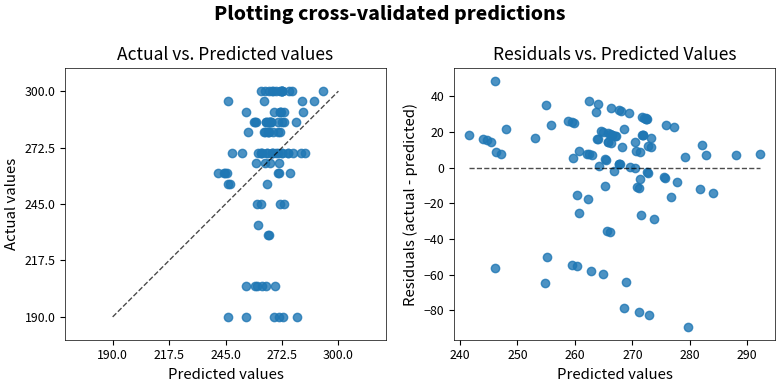

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values", fontweight="normal")

PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1],
)

axs[1].set_title("Residuals vs. Predicted Values", fontweight="normal")
fig.suptitle("Plotting cross-validated predictions", fontweight="bold")

fig.tight_layout()
# fig.savefig("../figures/group_kfold_cv_predictions_behavior.pdf")
fig.show()

In [17]:
groups = model_data["infant_id"]

# cv_inner = LeavePGroupsOut(n_groups=3)
# cv_outer = LeavePGroupsOut(n_groups=3)

cv_inner = GroupKFold(n_splits=10)
cv_outer = GroupKFold(n_splits=10)

param_grid = {"gradient_boosting__max_depth": np.linspace(3, 20, num=10, dtype=int),
              "pca__n_components": np.linspace(5, 50, num=10, dtype=int)}
best_params = {"gradient_boosting__max_depth": [], "pca__n_components": []}

pipe = Pipeline(
    steps=[
        ("replace", FunctionTransformer(multi_replace)),
        ("clr", FunctionTransformer(clr, validate=False)),
        ("pca", PCA()),
        # ("var", VarianceThreshold(1e-6)),
        # ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("gradient_boosting", GradientBoostingRegressor(n_estimators=1000)),
    ]
)

model_gbr = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_inner,
    scoring="neg_root_mean_squared_error",
    n_jobs=num_cpus,
    error_score="raise",
    verbose=True,
)

# Nested CV with access to per-fold best params
scoring_metrics = {"rmse": "neg_root_mean_squared_error", "mae": "neg_mean_absolute_error", "r2": "r2"}
cv_results = cross_validate(
    estimator=model_gbr,
    X=X,
    y=y,
    params = {'groups': groups},
    cv=cv_outer,
    scoring=scoring_metrics,
    n_jobs=num_cpus,
    return_estimator=True,
    return_train_score=True,
    verbose=1,
    error_score="raise",
)

y_pred = cross_val_predict(
    model_gbr, X=X, y=y, params = {'groups': groups}, cv=cv_outer, n_jobs=num_cpus, verbose=True
)

# pause for two seconds to let all threads finish printing their output
time.sleep(2)
print("\n*** Nested CV Results (Group K-Fold with PCA) ***")

rmse_per_fold = -cv_results["test_rmse"]
print(f"Outer-CV RMSE mean ± sd: {rmse_per_fold.mean():.2f} ± {rmse_per_fold.std(ddof=1):.2f}")

best_alphas = [est.best_params_["gradient_boosting__max_depth"] for est in cv_results["estimator"]]
print("Best tree max depth per outer fold:", best_alphas)

best_n_components = [est.best_params_["pca__n_components"] for est in cv_results["estimator"]]
print("Best n_components per outer fold:", best_n_components)

save_performance_metrics(cv_results, "Generalize to unseen infants: Group K-Fold with PCA (Gradient Boosting)")

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed: 11.9min remaining: 47.7min


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 12.4min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed: 11.8min remaining: 47.4min


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 12.3min finished



*** Nested CV Results (Group K-Fold with PCA) ***
Outer-CV RMSE mean ± sd: 29.34 ± 19.88
Best tree max depth per outer fold: [3, 3, 20, 4, 10, 3, 3, 3, 3, 8]
Best n_components per outer fold: [45, 10, 15, 10, 15, 10, 10, 15, 20, 5]
Performance metrics for 'Generalize to unseen infants: Group K-Fold with PCA (Gradient Boosting)' saved to ../data/results/model_performance_development.md


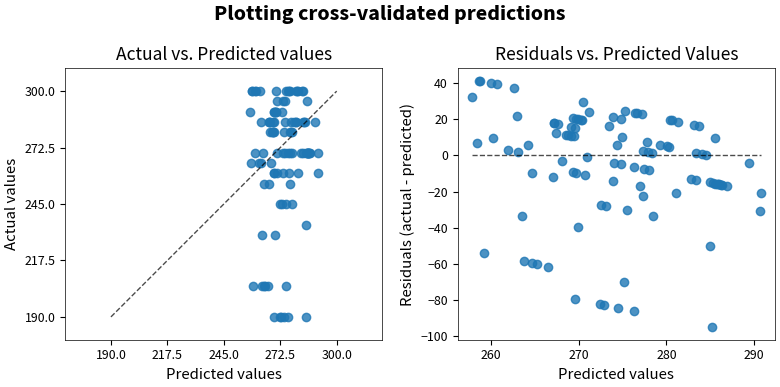

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values", fontweight="normal" )
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1],
)
axs[1].set_title("Residuals vs. Predicted Values", fontweight="normal")
fig.suptitle("Plotting cross-validated predictions", fontweight="bold")
plt.tight_layout()
plt.show()

# Predicting Sleep Quality

In [19]:
metadata = pd.read_csv(f"{data_dir}/raw/metadata_collapsed.tsv", sep="\t", header=0, index_col=0)
feature_table = Artifact.load(f"{data_dir}/raw/table_collapsed.qza").view(pd.DataFrame)

data = pd.merge(left=metadata, right=feature_table, left_index=True, right_index=True)

print(f"Original dataset size: {len(data)} samples")
sleep_model_data = data.dropna(subset=["sleep_quality"])
print(
    f"Dataset size after removing missing sleep quality values: {len(sleep_model_data)} samples"
)
print(f"Number of samples lost: {len(data) - len(sleep_model_data)} samples")

y = sleep_model_data.sleep_quality
X = sleep_model_data[features]

Original dataset size: 36 samples
Dataset size after removing missing sleep quality values: 31 samples
Number of samples lost: 5 samples


In [20]:

results_file_path = f"{data_dir}/results/model_performance_sleep_quality.md"

# Create the results file and any missing directories
os.makedirs(os.path.dirname(results_file_path), exist_ok=True)
with open(results_file_path, "w") as f:
    f.write("# Predicting Sleep Quality: Model Performance\n\n")

In [21]:
groups = sleep_model_data["infant_id"]

# cv_inner = LeavePGroupsOut(n_groups=3)
# cv_outer = LeavePGroupsOut(n_groups=3)

cv_inner = GroupKFold(n_splits=3)
cv_outer = GroupKFold(n_splits=3)

param_grid = {"lasso__alpha": np.logspace(-3, 1, num=10)}
best_params = {"lasso__alpha": []}

pipe = Pipeline(
    steps=[
        ("replace", FunctionTransformer(multi_replace)),
        ("clr", FunctionTransformer(clr, validate=False)),
        ("var", VarianceThreshold(1e-6)),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lasso", Lasso(max_iter=10000)),
    ]
)

model_loo = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_inner,
    scoring="neg_root_mean_squared_error",
    n_jobs=num_cpus,
    error_score="raise",
    verbose=True,
)

# Nested CV with access to per-fold best params
scoring_metrics = {"rmse": "neg_root_mean_squared_error", "mae": "neg_mean_absolute_error", "r2": "r2"}
cv_results = cross_validate(
    estimator=model_loo,
    X=X,
    y=y,
    params = {'groups': groups},
    cv=cv_outer,
    scoring=scoring_metrics,
    n_jobs=num_cpus,
    return_estimator=True,
    return_train_score=True,
    verbose=1,
    error_score="raise",
)

y_pred = cross_val_predict(
    model_loo, X=X, y=y, params = {'groups': groups}, cv=cv_outer, n_jobs=num_cpus, verbose=True
)

# pause for two seconds to let all threads finish printing their output
time.sleep(2)
print("\n*** Nested CV Results (Leave-P-Groups-Out Approach) ***")
rmse_per_fold = -cv_results["test_rmse"]
print("Outer-CV RMSE mean ± sd:", rmse_per_fold.mean(), "±", rmse_per_fold.std(ddof=1))
best_alphas = [est.best_params_["lasso__alpha"] for est in cv_results["estimator"]]
print("Best alpha per outer fold:", best_alphas)

save_performance_metrics(cv_results, "Generalize to unseen infants: Group K-Fold (Lasso)")

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:    0.4s finished



*** Nested CV Results (Leave-P-Groups-Out Approach) ***
Outer-CV RMSE mean ± sd: 0.12063132031125905 ± 0.03529232560665151
Best alpha per outer fold: [0.05994842503189409, 0.1668100537200059, 0.05994842503189409]
Performance metrics for 'Generalize to unseen infants: Group K-Fold (Lasso)' saved to ../data/results/model_performance_development.md


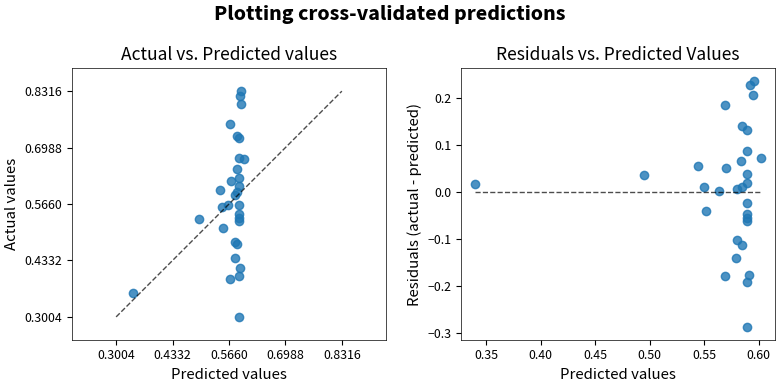

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values", fontweight="normal")

PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1],
)
axs[1].set_title("Residuals vs. Predicted Values", fontweight="normal")
fig.suptitle("Plotting cross-validated predictions", fontweight="bold")
fig.tight_layout()
fig.savefig("../figures/group_kfold_cv_predictions_sleep_quality.pdf")
fig.show()